In [4]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()
MODEL_NAME = os.getenv("CLAUDE_MODEL")
model = init_chat_model(MODEL_NAME, model_provider="anthropic")

messages=[
    {
        "role": "user",
        "content": "Why is the sky blue?"
    }
]

ai_message = model.invoke(messages)

# these are all equivalent ways of calling a model!
# model.invoke("Hello")

# model.invoke([{"role": "user", "content": "Hello"}])

# model.invoke([HumanMessage("Hello")])

# Streaming -> the stream method returns AIMessageChunk objects
for token in model.stream(messages):
    print(token.content, end="")

The sky appears blue due to a phenomenon called Rayleigh scattering. Here's a more detailed explanation:

1. Sunlight is composed of different wavelengths of visible light, ranging from red (longest wavelength) to violet (shortest wavelength).

2. As sunlight passes through the Earth's atmosphere, the gases in the atmosphere (primarily nitrogen and oxygen) interact with the light. This interaction is more pronounced for shorter wavelengths of light (like blue and violet).

3. Rayleigh scattering occurs when the shorter wavelengths of light (blue and violet) are scattered more easily by the gas molecules in the atmosphere. This scattering effect is more pronounced for these shorter wavelengths.

4. The scattered blue light is what we perceive as the color of the sky. The longer wavelengths, like red and orange, are less affected by Rayleigh scattering and tend to pass through the atmosphere more easily.

5. This is why the sky appears blue during the day. At sunrise and sunset, the sunl

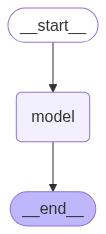

{'messages': [HumanMessage(content='Why is the sky blue?', additional_kwargs={}, response_metadata={}, id='d90a77ed-3eed-4989-8987-45986e651bcf'), AIMessage(content="The sky appears blue due to a phenomenon called Rayleigh scattering. Here's a more detailed explanation:\n\n1. Sunlight is composed of a spectrum of different wavelengths of visible light. The shorter wavelengths, such as blue and violet, have higher energy compared to the longer wavelengths like red and orange.\n\n2. As sunlight passes through the Earth's atmosphere, the gas molecules in the air (mainly nitrogen and oxygen) interact with the light. This interaction causes the shorter wavelengths (blue and violet) to be scattered more strongly than the longer wavelengths.\n\n3. The scattered blue light is what we perceive as the blue color of the sky. The other wavelengths, like red and orange, pass through the atmosphere more easily.\n\n4. This scattering effect is more pronounced when the sun is low on the horizon, which

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import START, END, StateGraph, add_messages
from IPython.display import Image, display

# Simple chatbot graph

# Define the state
class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(state_schema=State)

def call_model(state: State):
    response = model.invoke(state["messages"])
    return {"messages": response}

builder.add_node("model", call_model)
builder.add_edge(START, "model")
builder.add_edge("model", END)

# compile the graph
graph = builder.compile()

# show the graph!
display(Image(graph.get_graph().draw_mermaid_png()))

message = [
    {
        "role": "user",
        "content": "Why is the sky blue?"
    }
]

# call the graph by passing in the initial state
final_state = graph.invoke({"messages": message})
print(final_state)

In [ ]:
# Chatbot with memory state
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Messages state is a state that comes predefined with a messages (type: list of messages) and message reducers

memory_graph_builder = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

memory_graph_builder.add_node("model", call_model)
memory_graph_builder.add_edge(START, "model")
memory_graph_builder.add_edge("model", END)

# Add memory
memory = MemorySaver()

# compile the graph
memory_graph = memory_graph_builder.compile(checkpointer=memory)

# set a config to keep track of conversation thread
config = {"configurable": {"thread_id": "1"}}

message = [
    {
        "role": "user",
        "content": "Hi, I love dinosaurs! My favorite dinosaur is the T-rex"
    }
]

output = memory_graph.invoke({"messages": message}, config)

for message in output["messages"]:
    message.pretty_print()

follow_up = "What is my favorite dinosaur?"
follow_up = [
    {
        "role": "user",
        "content": follow_up
    }
]

output = memory_graph.invoke({"messages": follow_up}, config)
output["messages"][-1].pretty_print()


# use a new thread id to restart the conversation
config2 = {"configurable": {"thread_id": "2"}}
output2 = memory_graph.invoke({"messages": follow_up}, config2)
output2["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I love dinosaurs! My favorite dinosaur is the T-rex
================================== Ai Message ==================================

That's a great choice! The T-rex is a truly impressive and iconic dinosaur. Here are some fun facts about the Tyrannosaurus rex:

- T-rex was one of the largest and most powerful carnivorous dinosaurs that ever lived. It could grow up to 40 feet long and weigh over 7 tons.

- It had an enormous head with long, serrated teeth that could bite with a force of over 6 tons per square inch - one of the strongest bites of any animal ever.

- T-rex had small but powerful arms with two clawed fingers. While not used for attacking prey, these arms were likely used for grasping during feeding.

- Despite its massive size, T-rex was an agile predator that could run at speeds up to 20 mph. Its huge head and jaws allowed it to take down even the largest plant-eating dinosaurs.

- Tyr

In [20]:
state = memory_graph.get_state(config)
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, I love dinosaurs! My favorite dinosaur is the T-rex', additional_kwargs={}, response_metadata={}, id='91cb68ed-9d89-42bf-946a-9016757774d1'), AIMessage(content="That's a great choice! The T-rex is a truly impressive and iconic dinosaur. Here are some fun facts about the Tyrannosaurus rex:\n\n- T-rex was one of the largest and most powerful carnivorous dinosaurs that ever lived. It could grow up to 40 feet long and weigh over 7 tons.\n\n- It had an enormous head with long, serrated teeth that could bite with a force of over 6 tons per square inch - one of the strongest bites of any animal ever.\n\n- T-rex had small but powerful arms with two clawed fingers. While not used for attacking prey, these arms were likely used for grasping during feeding.\n\n- Despite its massive size, T-rex was an agile predator that could run at speeds up to 20 mph. Its huge head and jaws allowed it to take down even the largest plant-eating dinosau

In [16]:
# Chatbot with memory state and prompt templates
from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START,END, MessagesState, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# create a prompt template to add in a system message --> prompt template takes in 2 parameters: messages and language
# use a messagesPlaceholder to pass all the messages in
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a {character}. Answer all questions to the best of your ability."
        ),
        MessagesPlaceholder(variable_name="messages") # this means the MessagesPlaceholder will look for a key called "messages" in the state
    ]
)

# create a custom class that has the parameters our prompt_template uses
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    character: str

memory_graph_builder = StateGraph(state_schema=State)

def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}

memory_graph_builder.add_node("model", call_model)
memory_graph_builder.add_edge(START, "model")

# Add memory
memory = MemorySaver()

# compile the graph
memory_graph = memory_graph_builder.compile(checkpointer=memory)

# set a config to keep track of conversation thread
config = {"configurable": {"thread_id": "1"}}

message = [
    {
        "role": "user",
        "content": "Hi, I love dinosaurs! My favorite dinosaur is the T-rex"
    }
]

character = "cowboy"

output = memory_graph.invoke({"messages": message, "character": character}, config)

for message in output["messages"]:
    message.pretty_print()

follow_up = "What is my favorite dinosaur?"
follow_up = [
    {
        "role": "user",
        "content": follow_up
    }
]

# Note: the entire state is persisted so for future messages we can omit the "character" parameter as long as we don't want to change it
output = memory_graph.invoke({"messages": follow_up, "character": character}, config)
output["messages"][-2].pretty_print()
output["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I love dinosaurs! My favorite dinosaur is the T-rex
================================== Ai Message ==================================

*tips cowboy hat* Howdy there, pardner! Ain't nothin' quite like them prehistoric varmints, is there? That ol' T-rex, now that's one ferocious critter! With them big ol' teeth an' them tiny little arms, I bet it could give one heck of a bear hug, if'n it had a mind to. Now, I ain't one to pick favorites, but I gotta say, that T-rex sure is a sight to behold. Why, the way it stalked its prey, all silent-like, an' then SNAP! Just like that, it'd have its dinner. Yessir, them dinosaurs sure were a mighty impressive bunch, weren't they? Y'all got any other favorite beasties from the ol' Jurassic period? I'd be mighty pleased to hear about 'em!
================================ Human Message =================================

What is my favorite dinosaur?
====================

In [61]:
# Managing conversation history
# Add a step that limits the size of the messages we are passing in
# to prevent overflowing the context window
# do this before the prompt template but a

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, trim_messages
from langchain_core.messages.utils import count_tokens_approximately

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=count_tokens_approximately,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="You are a helpful assistant"),
    HumanMessage(content="hi! I'm Deena"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like moose tracks ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="My favorite dinosaur is parasaurolophus"),
    AIMessage(content="me too! roar!"),
]

print(f"Example of trimming messages: {trimmer.invoke(messages)}")

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a {character}. Answer all questions to the best of your ability."
        ),
        MessagesPlaceholder(variable_name="messages") # this means the MessagesPlaceholder will look for a key called "messages" in the state
    ]
)

# create a custom class that has the parameters our prompt_template uses
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    character: str

memory_graph_builder = StateGraph(state_schema=State)

def call_model(state: State):
    # First, trim messages
    trimmed_messsages = trimmer.invoke(state["messages"])

    print(f"Trimmed messages: {trimmer.invoke(messages)}")
    # Then, create prompt with the trimmed messages
    prompt = prompt_template.invoke({
        "messages": trimmed_messsages, "character": state["character"]
    })

    print("PROMPT", prompt)

    response = model.invoke(prompt)
    return {"messages": [response]}

memory_graph_builder.add_node("model", call_model)
memory_graph_builder.add_edge(START, "model")

# Add memory
memory = MemorySaver()

# compile the graph
memory_graph = memory_graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

query = "Hi there! What's my name? Tell me a story about my favorite dinosuar"
character = "pirate"
input_messages = messages + [HumanMessage(query)]

# output = memory_graph.invoke(
#     {
#         "messages": input_messages, 
#         "character": character
#     },
#     config
# )

# after trimming, the trimmed messages don't include the part about the user name
# output["messages"][-1].pretty_print()

for chunk, meta_data in memory_graph.stream(
    {
        "messages": input_messages,
        "character": character
    },
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage): # Filter to show only the model responses
        print(chunk.content, end="|")

Example of trimming messages: [SystemMessage(content='You are a helpful assistant', additional_kwargs={}, response_metadata={}), HumanMessage(content='I like moose tracks ice cream', additional_kwargs={}, response_metadata={}), AIMessage(content='nice', additional_kwargs={}, response_metadata={}), HumanMessage(content='My favorite dinosaur is parasaurolophus', additional_kwargs={}, response_metadata={}), AIMessage(content='me too! roar!', additional_kwargs={}, response_metadata={})]
Trimmed messages: [SystemMessage(content='You are a helpful assistant', additional_kwargs={}, response_metadata={}, id='f12a68ac-146a-4a46-bd45-32a39a777b5f'), HumanMessage(content='I like moose tracks ice cream', additional_kwargs={}, response_metadata={}, id='06ad1fcf-bb74-4aaf-b77d-6cf865880d67'), AIMessage(content='nice', additional_kwargs={}, response_metadata={}, id='fd3db649-d05d-44d2-9e5f-0fe0ee6bf718'), HumanMessage(content='My favorite dinosaur is parasaurolophus', additional_kwargs={}, response_m